In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import sqlalchemy as db
# from sqlalchemy import create_engine
# from sqlalchemy import MetaData 
# from sqlalchemy import Table

In [2]:
widths = (8,7,4,13,43)
header_pd = pd.read_fwf('../databases/Labeled_data.txt', widths = widths,skiprows=7, nrows=27)
labeled_data = pd.read_csv('../databases/Labeled_data.txt', header=None, delim_whitespace=True, skiprows=37) # extract data
labeled_data.columns = header_pd.iloc[:,3]
labeled_data.head()
#shuffle data
labeled_data_sampled = labeled_data.sample(n=10000, random_state=1)

In [3]:
labeled_data_sampled.head()

-------------,ID,SourceID,RAdeg,DEdeg,Per,R21,phi21,T0,gmag,rmag,...,phi21_r,R2_g,R2_r,Amp_g,Amp_r,log(FAP_g),log(FAP_r),Type,Dmin_g,Dmin_r
487837,ZTFJ194013.88+123401.3,487839,295.05785,12.56705,4.862086,0.091,4.208,58662.346787,18.268,17.089,...,4.208,0.252,0.530,0.075,0.065,-3.206,-12.875,RSCVN,0.0,0.0
271693,ZTFJ182806.98+011859.4,271695,277.02911,1.31651,90.994135,0.153,9.073,58628.076116,19.924,16.160,...,9.073,0.345,0.757,0.461,0.413,-0.855,-4.747,SR,0.0,0.0
570006,ZTFJ200451.65-090628.4,570008,301.21524,-9.10789,0.609388,0.320,3.705,58344.305057,19.157,18.872,...,3.705,0.843,0.912,1.175,0.630,-1.919,-3.350,RR,0.0,0.0
437924,ZTFJ192656.26+264100.6,437926,291.73444,26.68351,77.540677,0.054,5.404,58266.173729,16.601,14.069,...,5.404,0.475,0.592,0.347,0.213,-12.750,-16.989,SR,0.0,0.0
331493,ZTFJ185629.89-050650.2,331495,284.12455,-5.11396,73.156724,0.316,9.205,58377.990189,19.419,16.628,...,9.205,0.458,0.678,0.561,0.365,-4.594,-8.039,SR,0.0,0.0


In [4]:
engine = db.create_engine('sqlite:///../databases/save_LC.db', echo=False)
sqlite_connection = engine.connect()
metadata = db.MetaData()
data = db.Table('ZTFJ182806.98+011859.4', metadata, autoload=True, autoload_with=engine)
print(data.columns.keys())

['index', 'oid', 'expid', 'hjd', 'mjd', 'mag', 'magerr', 'catflags', 'filtercode', 'ra', 'dec', 'chi', 'sharp', 'filefracday', 'field', 'ccdid', 'qid', 'limitmag', 'magzp', 'magzprms', 'clrcoeff', 'clrcounc', 'exptime', 'airmass', 'programid']


In [5]:
metadata = db.MetaData()
metadata.reflect(bind=engine)
for table in metadata.sorted_tables:
    print(table)

ZTFJ182806.98+011859.4
ZTFJ185629.89-050650.2
ZTFJ192656.26+264100.6
ZTFJ194013.88+123401.3
ZTFJ200451.65-090628.4


In [6]:

#Equivalent to 'SELECT * FROM census'
query = db.select([data])
ResultProxy = sqlite_connection.execute(query)
ResultSet = ResultProxy.fetchall()


In [7]:
df = pd.DataFrame(ResultSet)
df.columns = ResultSet[0].keys()

In [8]:
circle_radius = 0.00028 # 1 arcsec = 0.00028 degress
t_format = "ipac_table"
table_format = "FORMAT=" + str(t_format)
flag_mask = 32768
mask = "BAD_CATFLAGS_MASK=" + str(flag_mask)
collect="COLLECTION="+"ztf_dr2"
numobs = "NOBS_MIN=20"
filter_band = "g"
label = []
SourceID =[]
start_time = time.time()
i = 100000
j = 100000
ra = labeled_data.RAdeg[i]
dec = labeled_data.DEdeg[i]
circle = "POS=CIRCLE"+"+"+str(ra)+"+"+str(dec)+"+"+str(circle_radius)
band = "BANDNAME="+ filter_band
params = circle + "&" +  mask + "&" + numobs + "&" + collect + "&" + table_format

url1= "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?" + params
data1 = pd.read_csv(url1, header=None, delim_whitespace=True, skiprows=55) # extract data
header = pd.read_csv(url1, header=None, sep='|', skiprows=50,usecols=range(1,25), nrows=1)
data1.columns = header.iloc[0].str.strip()


url2 = 'http://variables.cn:88/seldataz.php?SourceID=' + str(labeled_data.SourceID[j])
data2 = pd.read_csv(url2, header='infer')

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   oid          180 non-null    int64  
 1   expid        180 non-null    int64  
 2   hjd          180 non-null    float64
 3   mjd          180 non-null    float64
 4   mag          180 non-null    float64
 5   magerr       180 non-null    float64
 6   catflags     180 non-null    int64  
 7   filtercode   180 non-null    object 
 8   ra           180 non-null    float64
 9   dec          180 non-null    float64
 10  chi          180 non-null    float64
 11  sharp        180 non-null    float64
 12  filefracday  180 non-null    int64  
 13  field        180 non-null    int64  
 14  ccdid        180 non-null    int64  
 15  qid          180 non-null    int64  
 16  limitmag     180 non-null    float64
 17  magzp        180 non-null    float64
 18  magzprms     180 non-null    float64
 19  clrcoeff

In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SourceID  181 non-null    int64  
 1   RAdeg     181 non-null    float64
 2   DEdeg     181 non-null    float64
 3   HJD       181 non-null    float64
 4   mag       181 non-null    float64
 5   e_mag     181 non-null    float64
 6   flag      181 non-null    int64  
 7   band      181 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 11.4+ KB


In [11]:
print(labeled_data.SourceID[i])

100002


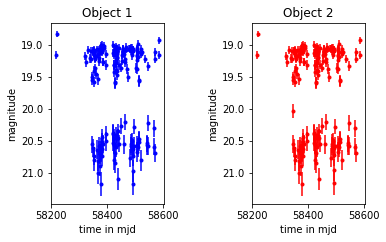

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
ax = axs[0]
ax.errorbar(data1['mjd'],data1['mag'],yerr = data1['magerr'],fmt='b.')
ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
ax.set_xlabel ('time in mjd')
ax.set_ylabel('magnitude')
ax.set_title('Object 1')

ax = axs[1]
ax.errorbar(data2['HJD'],data2['mag'],yerr = data2['e_mag'],fmt='r.')
ax.invert_yaxis() # smaller magnitude means brighter stars, so invert the axis
ax.set_xlabel('time in mjd')
ax.set_ylabel('magnitude')
ax.set_title('Object 2')

fig.tight_layout(pad=3.0)
plt.show()

In [26]:
data1.tail(100)

,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,...,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
80,609201100001565,73617046,2.458491e+06,58490.170463,19.160423,0.066395,0,zr,72.528938,23.964291,...,1,1,21.100000,26.118324,0.019715,0.087789,0.000006,30,1.046,1
81,609201100001565,73926122,2.458494e+06,58493.261227,19.083475,0.062985,0,zr,72.528957,23.964308,...,1,1,21.059999,26.113297,0.019707,0.086010,0.000006,30,1.045,1
82,609201100001565,75026321,2.458505e+06,58504.263218,19.363594,0.076345,0,zr,72.528988,23.964272,...,1,1,19.379999,25.744453,0.038356,0.062108,0.000022,30,1.115,1
83,609201100001565,75321924,2.458508e+06,58507.219248,19.078957,0.062791,0,zr,72.528922,23.964300,...,1,1,20.650000,26.107744,0.021670,0.079210,0.000007,30,1.040,1
84,609201100001565,75328646,2.458508e+06,58507.286470,19.376106,0.077004,0,zr,72.528863,23.964366,...,1,1,20.530001,26.149956,0.022016,0.069121,0.000007,30,1.232,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,610204200001499,76819293,2.458523e+06,58522.192940,19.142572,0.062346,0,zr,72.528914,23.964319,...,4,2,21.290001,26.124703,0.022320,0.081996,0.000008,30,1.031,1
176,610204200001499,77217725,2.458527e+06,58526.177257,19.110187,0.060941,0,zr,72.528889,23.964293,...,4,2,20.770000,26.135361,0.019728,0.083275,0.000006,30,1.026,1
177,610204200001499,78019383,2.458535e+06,58534.193831,19.214247,0.065577,0,zr,72.528993,23.964272,...,4,2,19.590000,26.136435,0.035978,0.067985,0.000020,30,1.093,1
178,610204200001499,81913270,2.458574e+06,58573.132708,19.110439,0.060952,0,zr,72.528868,23.964305,...,4,2,20.170000,26.028334,0.024991,0.087849,0.000010,30,1.259,1


In [14]:
data2.head(100)

,SourceID,RAdeg,DEdeg,HJD,mag,e_mag,flag,band
0,100002,72.528927,23.964307,58450.40882,20.273,0.126,0,g
1,100002,72.528927,23.964307,58374.47778,20.715,0.157,0,g
2,100002,72.528927,23.964307,58351.46413,20.809,0.163,0,g
3,100002,72.528927,23.964307,58491.19062,20.733,0.158,0,g
4,100002,72.528927,23.964307,58494.18168,20.623,0.151,0,g
...,...,...,...,...,...,...,...,...
95,100002,72.528944,23.964321,58431.31684,19.124,0.064,0,r
96,100002,72.528944,23.964321,58507.29032,19.376,0.077,0,r
97,100002,72.528944,23.964321,58348.44996,19.101,0.063,0,r
98,100002,72.528944,23.964321,58431.30030,19.267,0.071,0,r


In [25]:
labeled_data.tail(10)

-------------,ID,SourceID,RAdeg,DEdeg,Per,R21,phi21,T0,gmag,rmag,...,phi21_r,R2_g,R2_r,Amp_g,Amp_r,log(FAP_g),log(FAP_r),Type,Dmin_g,Dmin_r
781591,ZTFJ235958.21+595322.6,781595,359.99257,59.88963,0.476594,0.036,6.535,58301.449595,18.066,17.195,...,6.535,0.704,0.813,0.186,0.171,-30.896,-43.850,EW,0.016,0.012
781592,ZTFJ235958.35+703634.9,781596,359.99313,70.60972,0.355792,0.328,6.288,58322.378712,18.691,17.624,...,6.288,0.944,0.986,0.723,0.683,-29.676,-33.249,EW,0.025,0.071
781593,ZTFJ235958.45+482611.7,781597,359.99358,48.43659,0.288055,0.266,6.392,58464.265978,15.898,15.298,...,6.300,0.828,0.795,0.105,0.094,-6.663,-4.822,EW,0.014,0.008
781594,ZTFJ235958.48+684200.6,781598,359.99369,68.70019,147.642302,0.256,5.975,58261.468212,18.863,15.534,...,5.975,0.533,0.644,0.727,0.536,-18.132,-21.327,SR,0.000,0.000
781595,ZTFJ235958.62+561627.3,781599,359.99429,56.27426,111.584841,0.151,5.162,58277.348115,12.656,0.000,...,0.000,0.436,0.000,0.064,0.000,-9.196,0.000,SR,0.000,0.000
781596,ZTFJ235958.71+540330.3,781600,359.99464,54.05844,0.316120,0.045,4.957,58285.403066,17.257,16.328,...,4.957,0.699,0.823,0.188,0.142,-14.759,-23.381,EW,0.063,0.016
781597,ZTFJ235958.84+625544.8,781601,359.99519,62.92912,0.299463,0.411,5.821,58279.407313,18.199,17.279,...,5.821,0.201,0.746,0.075,0.093,-4.014,-12.209,EW,0.005,0.008
781598,ZTFJ235959.18+532742.2,781602,359.99662,53.46174,0.512445,0.129,6.035,58365.349426,15.075,14.780,...,6.035,0.960,0.971,0.190,0.196,-26.888,-28.835,EW,0.025,0.027
781599,ZTFJ235959.38+683701.0,781603,359.99742,68.61696,0.471284,0.112,6.061,58358.415607,19.130,18.096,...,6.061,0.720,0.910,0.423,0.367,-23.633,-33.909,EW,0.078,0.066
781600,ZTFJ235959.45+522533.1,781604,359.99775,52.42587,2.413463,0.042,5.519,58289.460237,17.831,17.076,...,5.519,0.410,0.545,0.076,0.076,-9.747,-15.024,RSCVN,0.000,0.000


In [16]:
df_100000 = labeled_data[:100000]

<AxesSubplot:xlabel='Type', ylabel='Count'>

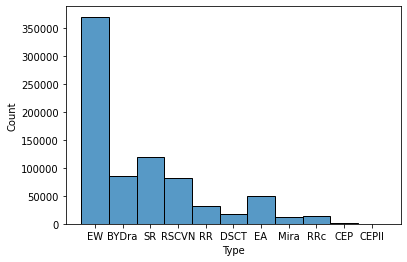

In [17]:
import seaborn as sns
sns.histplot(data=labeled_data, x=labeled_data.Type)

In [18]:
labeled_data.Type.value_counts()

EW       369707
SR       119261
BYDra     84696
RSCVN     81393
EA        49943
RR        32518
DSCT      16709
RRc       13875
Mira      11879
CEP        1262
CEPII       358
Name: Type, dtype: int64

In [19]:
lc = data2.drop(columns = ['SourceID','flag'])

In [20]:
print(lc.columns)

Index(['RAdeg', 'DEdeg', 'HJD', 'mag', 'e_mag', 'band'], dtype='object')


In [21]:
lc2 = data1[['ra','dec','hjd','mag','magerr','filtercode']]
col_names = lc.columns.values.tolist()

lc2.columns=['RAdeg', 'DEdeg', 'HJD', 'mag', 'e_mag', 'band']

In [22]:
lc2.band.unique()

array(['zg', 'zr'], dtype=object)

In [23]:
lc2.loc[lc2['band']=='zg']='g'
lc2.loc[lc2['band']=='zr']='r'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [24]:
lc2.band.unique()

array(['g', 'r'], dtype=object)

In [49]:
dfr = data2.loc[data2['band']=='r']
dfr.head()

dfg = data2.loc[data2['band']=='g']
dfg.head()

,SourceID,RAdeg,DEdeg,HJD,mag,e_mag,flag,band
0,100002,72.528927,23.964307,58450.40882,20.273,0.126,0,g
1,100002,72.528927,23.964307,58374.47778,20.715,0.157,0,g
2,100002,72.528927,23.964307,58351.46413,20.809,0.163,0,g
3,100002,72.528927,23.964307,58491.19062,20.733,0.158,0,g
4,100002,72.528927,23.964307,58494.18168,20.623,0.151,0,g


In [50]:
e_mag = dfr.e_mag.values
mag = dfr.mag.values

In [51]:
w = 1/(e_mag*e_mag)
sw = np.sum(w)
wmag = w*mag
wmean = np.sum(wmag)/sw

In [52]:
print(wmean)

19.156596576841544


In [53]:
e_mag = dfg.e_mag.values
mag = dfg.mag.values

w = 1/(e_mag*e_mag)
sw = np.sum(w)
wmag = w*mag
wmean = np.sum(wmag)/sw
print(wmean)

20.562416083262757


In [55]:
def weighted_mean(mag,mag_err):
    mag2 = (mag_err*mag_err) # mag err square
    mag2_inv = 1/mag2.values; # take inverse of the values
    w = pd.Series(mag2_inv) # covert it back to s series
    sw = w.sum() # sum of weights
    wmag = mag*w # multiply magnitude with weights
    wmean = wmag.sum()/sw # weighted mean
    return wmean

In [57]:
def weighted_mean2(mag,e_mag):
    w = 1/(e_mag*e_mag)
    sw = np.sum(w)
    wmag = w*mag
    wmean = np.sum(wmag)/sw
    return wmean

In [59]:
wmean_g = weighted_mean2(dfg.mag.values,dfg.e_mag.values)
wmean_r = weighted_mean2(dfr.mag.values,dfr.e_mag.values)
print(wmean_g)
print(wmean_r)

20.562416083262757
19.156596576841544
